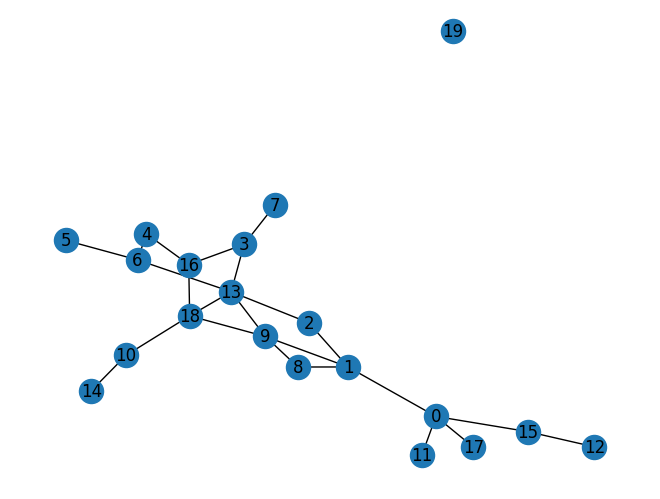

Cluster assignments:
{0: [0, 11, 12, 15, 17], 1: [19], 2: [1, 2, 8, 9, 13], 3: [3, 4, 5, 6, 7, 16], 4: [10, 14, 18]}


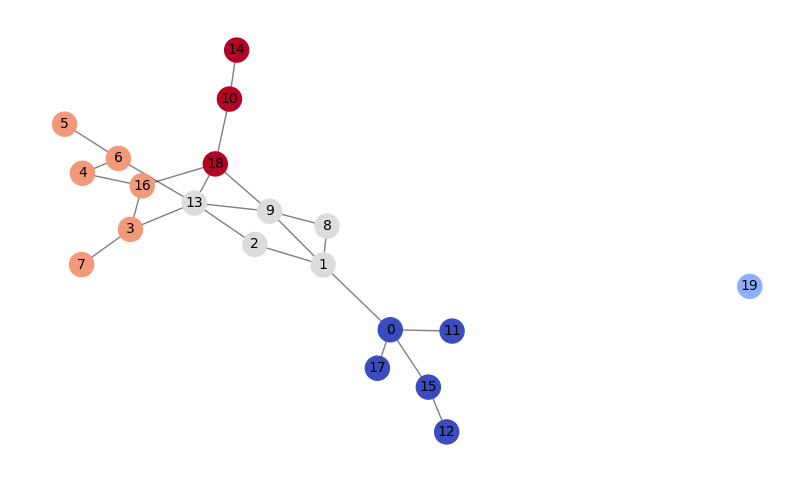

In [22]:
import networkx as nx
import community  # Libreria python-louvain per la modolarità
import matplotlib.pyplot as plt

# Creazione di un grafo casuale con n nodi e m archi
G = nx.gnm_random_graph(n=20, m=23)

# visualizzazione del grafo
nx.draw(G, with_labels=True)
plt.show()

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Creiamo i sottoinsiemi V1, ..., Vk basati sulle etichette dei cluster
k = max(partition.values()) + 1  # Numero di cluster ottenuto
partition_dict = {i: [] for i in range(k)}
for node, label in partition.items():
    partition_dict[label].append(node)

# Stampa dell'output: dizionario dei cluster
print("Cluster assignments:")
print(partition_dict)


#Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(10, 6))
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

plt.show()


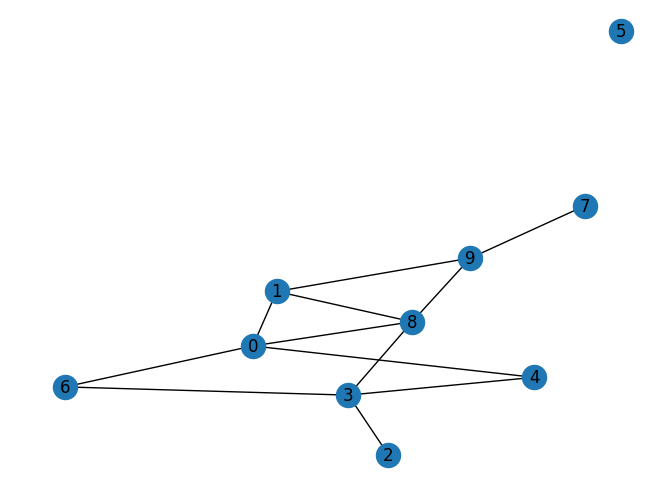

Cluster assignments:
{0: [0, 2, 3, 4, 6], 1: [1, 7, 8, 9], 2: [5]}


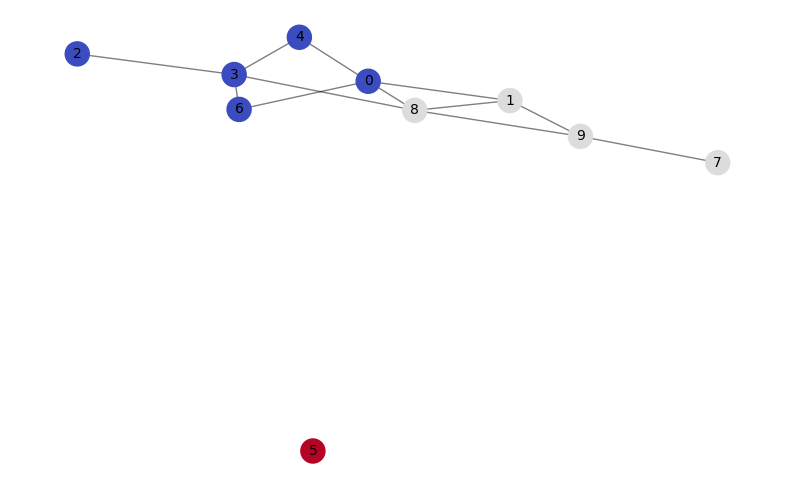

Dimensione del multi-cut minimo: 2


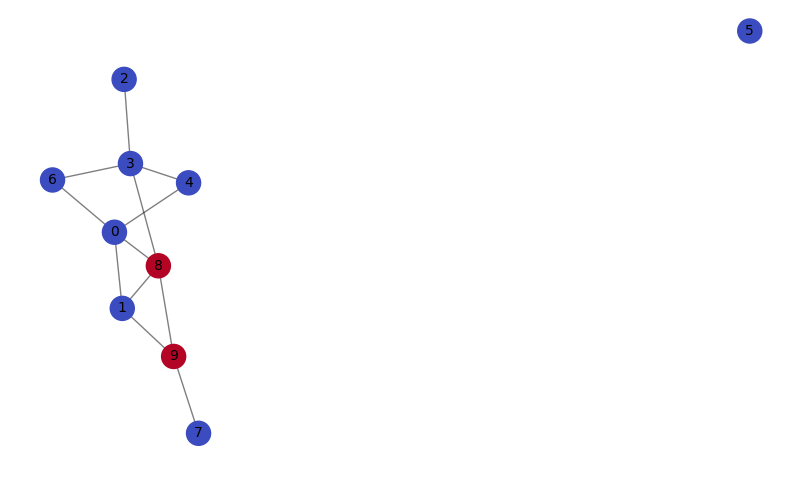

In [38]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=12, seed=42)  # Aggiungi 'seed' per riproducibilità

# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Visualizzazione del grafo
nx.draw(G, with_labels=True)
plt.show()


# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Creiamo i sottoinsiemi V1, ..., Vk basati sulle etichette dei cluster
k = max(partition.values()) + 1  # Numero di cluster ottenuto
partition_dict = {i: [] for i in range(k)}
for node, label in partition.items():
    partition_dict[label].append(node)

# Stampa dell'output: dizionario dei cluster
print("Cluster assignments:")
print(partition_dict)


#Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(10, 6))
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

plt.show()

# Scegli i nodi sorgente e destinazione per l'algoritmo Max-Flow Min-Cut
source_node = 0
target_node = 9

# Troviamo il taglio minimo utilizzando l'algoritmo Max-Flow Min-Cut
cut_value, partition = nx.minimum_cut(G, source_node, target_node)

# La variabile 'cut_value' conterrà la dimensione del multi-cut minimo
print("Dimensione del multi-cut minimo:", cut_value)

# La variabile 'partition' conterrà una partizione del grafo in due sottoinsiemi
# dove i nodi con valore 0 fanno parte della sorgente e i nodi con valore 1 fanno parte della destinazione
set_source, set_target = partition

# Riassegniamo 'partition' per ottenere il dizionario dei cluster
partition_dict = {0: set_source, 1: set_target}

# Creiamo un dizionario di colori personalizzato per mappare ciascun cluster a un valore numerico
color_map = {node: idx for idx, nodes in partition_dict.items() for node in nodes}

""" # Per visualizzare i cluster, puoi utilizzare il seguente codice:
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(10, 6))
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

plt.show() """


#Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(10, 6))
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)

# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

plt.show()


Cluster assignments:
{0: [0, 1, 7, 8, 9], 1: [2, 3, 4, 6], 2: [5]}
Dimensione del multi-cut minimo: 2


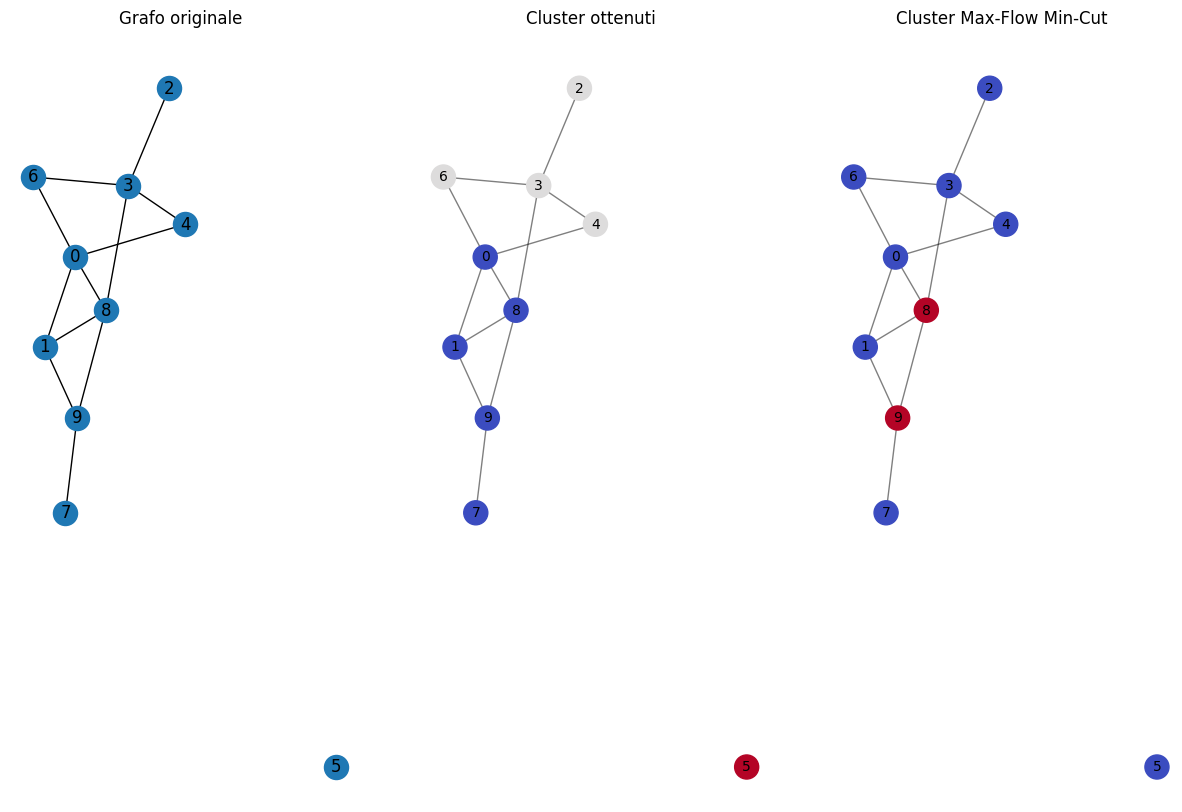

In [41]:
import networkx as nx
import matplotlib.pyplot as plt

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=12, seed=42)  # Aggiungi 'seed' per riproducibilità

# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Creiamo i sottoinsiemi V1, ..., Vk basati sulle etichette dei cluster
k = max(partition.values()) + 1  # Numero di cluster ottenuto
partition_dict = {i: [] for i in range(k)}
for node, label in partition.items():
    partition_dict[label].append(node)

# Stampa dell'output: dizionario dei cluster
print("Cluster assignments:")
print(partition_dict)

# La variabile 'cut_value' conterrà la dimensione del multi-cut minimo
print("Dimensione del multi-cut minimo:", cut_value)

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()


